# Newspaper Segmentation

Network backbone is a Resnet101

In [1]:
import os
import re
import sys
import cv2
import math
import json
import time
import random
import skimage
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Root directory of the project
ROOT_DIR = os.path.abspath("")
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs") # Directory to save logs and trained model
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5") # Local path to trained weights file

if not os.path.exists(COCO_MODEL_PATH): # Download COCO trained weights
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    NAME = "newspapers"
    GPU_COUNT = 1 # Train on 1 GPU and 8 images per GPU.
    IMAGES_PER_GPU = 8 # Batch size is 8 (GPUs * images/GPU).
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    IMAGE_RESIZE_MODE = 'square' #square or pad64 or crop
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels to extract low resolution 
    TRAIN_ROIS_PER_IMAGE = 32
    
    STEPS_PER_EPOCH = 100  # Use a small epoch since the data is simple
    VALIDATION_STEPS = 5 # use small validation steps since the epoch is small
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=12):
    """Return a Matplotlib Axes"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

* load_image()
* load_mask()
* image_reference()

In [4]:
class newspaperDataset(utils.Dataset):
    
    def load_data(self, dataset_dir, subset):
        """
        Load a subset of the newspaper dataset.
            
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        self.add_class("newspaper", 0, "article")
        self.add_class("newspaper", 1, "non-article")
        self.add_class("newspaper", 2, "title")

        assert subset in ["train", "test", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        filenames = list(annotations.keys())
        annotations = list(annotations.values())

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            shapes = [r['shape_attributes'] for r in a['regions'].values()]
            classes = [r['region_attributes']['label'] for r in a['regions'].values()]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "newspaper",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                shapes=shapes,
                classes=classes)
            
        return filenames

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "newspaper":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        classes = info['classes']
        
        mask = np.zeros([info["height"], info["width"], len(info["shapes"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["shapes"]):
            if p['name'] == 'polygon':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1
                
            if p['name'] == 'rectangle':
                start = (int(p['ymin']),int(p['xmin']))
                extent = (int(p['ymax']),int(p['xmax']))
                
                rr, cc = skimage.draw.rectangle(start=start, extent=extent, shape=mask.shape)
                mask[rr, cc, i] = 1
                
        class_ids = np.array([self.class_names.index(s) for s in classes])
        
        return mask, class_ids
    
    def image_reference(self, image_id):

        info = self.image_info[image_id]
        if info["source"] == "newspaper":
            return info["newspaper"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [5]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_train = newspaperDataset()
data_names_train = dataset_train.load_data(data_DIR, "train")
dataset_train.prepare()

In [6]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_test = newspaperDataset()
data_names_test = dataset_test.load_data(data_DIR, "test")
dataset_test.prepare()

In [7]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_val = newspaperDataset()
data_names_val = dataset_val.load_data(data_DIR, "val")
dataset_val.prepare()

In [8]:
dataset_val.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

### Useful functions

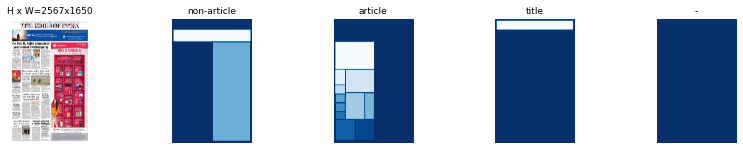

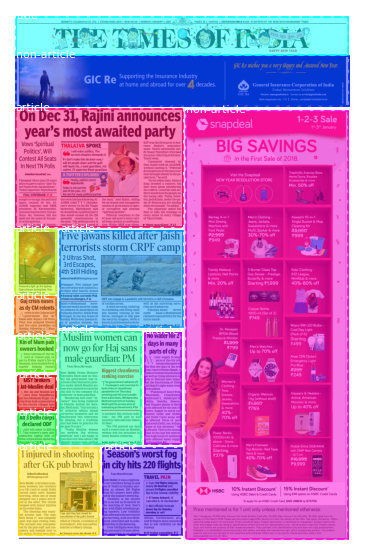

image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (128, 128, 14)        min:    0.00000  max:    1.00000  uint8


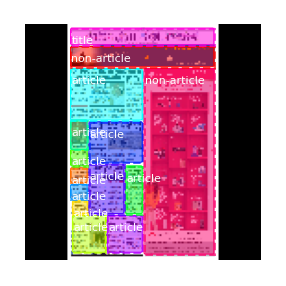

In [9]:
" ============= Display some sample dataset informations ============="

for ids in dataset_train.image_ids[:1]:
    mask, class_ids = dataset_train.load_mask(ids)
    bbox = utils.extract_bboxes(mask)
    
    image_path = data_DIR+'/train/'+data_names_train[ids]
    image = skimage.io.imread(image_path)

    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names, figsize=(10, 10))
    
    image, window, scale, padding, _ = utils.resize_image(
        image, 
        min_dim=config.IMAGE_MIN_DIM, 
        max_dim=config.IMAGE_MAX_DIM,
        mode='square')
    mask = utils.resize_mask(mask, scale, padding)
    
    log("image", image)
    log("mask", mask)
    
    bbox = utils.extract_bboxes(mask)
    visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names,figsize=(5, 5))

In [71]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [72]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 12


In [73]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

No GPU


In [74]:
tf.test.is_gpu_available(cuda_only=True)
# tf.config.list_physical_devices('GPU')

False

In [75]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11206377518362020322
]


In [76]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='all')


Starting at epoch 12. LR=0.001

Checkpoint Path: C:\Users\jeeva\Desktop\Ph.D_Project\Newspaper_Segmentation-master\codes\02_modelling\logs\newspapers20220115T0157\mask_rcnn_newspapers_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_

100/100 [==============================] - 4277s 43s/step - batch: 49.5000 - size: 8.0000 - loss: 0.1355 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0524 - val_loss: 3.1739 - val_rpn_class_loss: 0.1070 - val_rpn_bbox_loss: 1.0583 - val_mrcnn_class_loss: 1.0792 - val_mrcnn_bbox_loss: 0.3599 - val_mrcnn_mask_loss: 0.5696
Epoch 14/20
100/100 [==============================] - 4056s 41s/step - batch: 49.5000 - size: 8.0000 - loss: 0.1156 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0109 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.0481 - val_loss: 3.6122 - val_rpn_class_loss: 0.1392 - val_rpn_bbox_loss: 1.3647 - val_mrcnn_class_loss: 1.1971 - val_mrcnn_bbox_loss: 0.3541 - val_mrcnn_mask_loss: 0.5572
Epoch 15/20
100/100 [==============================] - 4743s 47s/step - batch: 49.5000 - size: 8.0000 - loss: 0.1128 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.

KeyboardInterrupt: 

In [32]:
model.load_weights(model_path, by_name=True)

Re-starting from epoch 12


In [87]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

model_path = os.path.join(r"logs\newspapers20220115T0157", "mask_rcnn_newspapers_0016.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Loading weights from  logs\newspapers20220115T0157\mask_rcnn_newspapers_0016.h5
Re-starting from epoch 16


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 2567.00000  float64
gt_class_id              shape: (8,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (8, 4)                min:    2.00000  max:  125.00000  int32
gt_mask                  shape: (128, 128, 8)         min:    0.00000  max:    1.00000  uint8
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


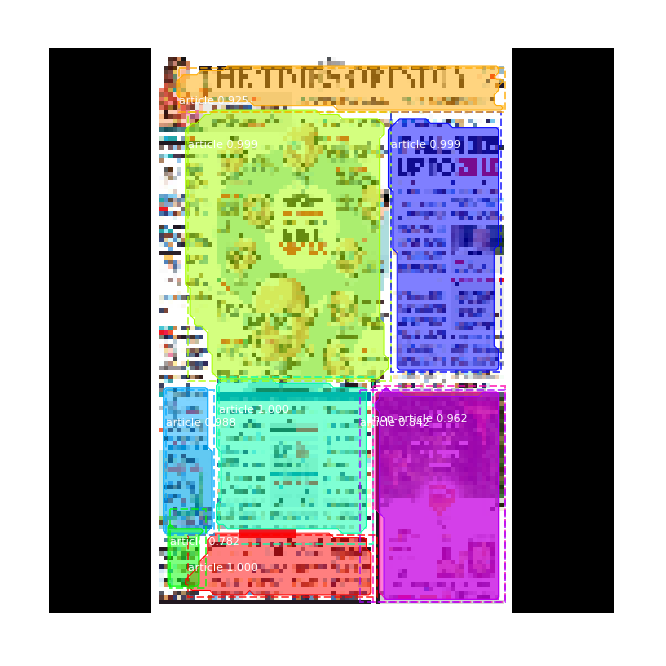

In [98]:
# Test on a random image
# image_id = random.choice(dataset_test.image_ids)

image_id = 7
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [86]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

AssertionError: len(images) must be equal to BATCH_SIZE

target_rpn_match         shape: (4092,)               min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.76777  max:    2.45878  float64
positive_anchors         shape: (4, 4)                min:   25.37258  max:  123.31371  float64
negative_anchors         shape: (252, 4)              min:  -22.62742  max:  131.31371  float64
neutral anchors          shape: (3836, 4)             min:  -90.50967  max:  154.50967  float64
refined_anchors          shape: (4, 4)                min:   25.00000  max:  124.99999  float32


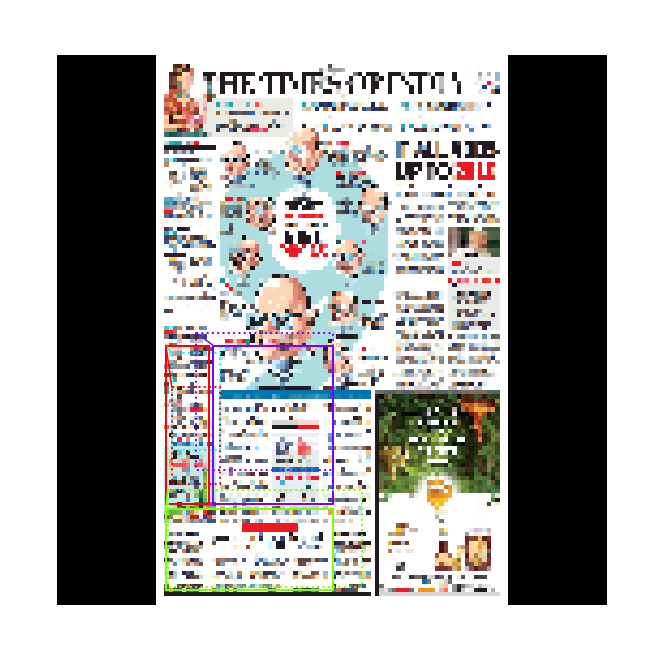

In [113]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    original_image.shape, model.anchors, gt_class_id[1:4], gt_bbox[1:4], model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(original_image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())


In [111]:
gt_class_id

array([2, 1, 1, 1, 2, 1, 2, 3])

In [103]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 14)
APs = []
Prec = []
Recall = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    Prec.append(np.mean(precisions))
    Recall.append(np.mean(recalls))
    
    
print("mAP: ", np.mean(APs))


mAP:  0.3462733584247073


In [ ]:
print("mPrec: ", np.mean(Prec))
print("mRecall: ", np.mean(Recall))

In [108]:
APs

[0.02083333395421505,
 1.0,
 0.4000000059604645,
 0.36723601498774117,
 0.05000000074505806,
 0.0,
 0.08163265671048846,
 0.23697916666666666,
 0.02083333395421505,
 0.23697916666666666,
 0.333333338300387,
 1.0,
 1.0,
 0.1]

In [104]:
Prec

[0.20208333333333334,
 0.6666666666666666,
 0.6944444444444443,
 0.7553669240975742,
 0.20208333333333334,
 0.0,
 0.25396825396825395,
 0.6717171717171717,
 0.20208333333333334,
 0.6717171717171717,
 0.6047619047619047,
 0.6666666666666666,
 0.6666666666666666,
 0.3173881673881674]

In [107]:
Recall

[0.15625000093132257,
 0.6666666666666666,
 0.4000000034769376,
 0.29748283424659777,
 0.2000000011175871,
 0.14285714285714285,
 0.190476194024086,
 0.25,
 0.15625000093132257,
 0.25,
 0.3714285748345511,
 0.6666666666666666,
 0.6666666666666666,
 0.2159090909090909]

In [ ]:
None